In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
from pprint import pprint
from pathlib import Path
from random import randint

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
import nibabel as nib
import glmsingle
from glmsingle.glmsingle import GLM_single
import bids
from bids import BIDSLayout
from scipy.ndimage import zoom, binary_dilation
import h5py
import nibabel as nib
from einops import rearrange

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from tc2see import load_data
from utils import rand_cmap

In [2]:
dataset_root = Path('D:\\Datasets')
tc2see_version = 3 # [1, 2]
dataset_path = dataset_root / f"TC2See_v{tc2see_version}"
derivatives_path = dataset_path / 'derivatives_TC2See_prdgm'

In [53]:
subject = 'sub-03'
tr_offsets = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,]
bold, stimulus_ids, mask, affine = load_data(
    derivatives_path / f'tc2see-v{tc2see_version}-bold.hdf5', 
    subject,
    tr_offset=tr_offsets,
    run_normalize='linear_trend',
    interpolation=False
)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.63it/s]
G:\Github Repositories\Google Drive\Repositories\fmri-preprocessing\tc2see.py:67: RuntimeWarning: Mean of empty slice
g:\python_env\fmri-preprocessing\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  7.24it/s]


In [54]:
#nc_file = 'noise_ceiling/sub-01/sub-01__time-linspace_0_6_13__interpolation-false__noise-ceiling.nii.gz'
nc_file = f'noise_ceiling/{subject}/{subject}__noise-ceiling.nii.gz'
nc_series = nib.load(derivatives_path / nc_file).get_fdata()
component = 4 #8
nc_volume = nc_series[..., component]
nc_volume[:, :, :5] = 0.
nc = nc_volume[mask]
nc.shape

(188290,)

In [70]:
nc_threshold = 10.
bold_best = bold[..., nc > nc_threshold]
bold_best_nan = np.isnan(bold_best)
bold_best[bold_best_nan] = 0.
bold_best_nan.sum()
X = rearrange(bold_best, 't p v -> (p v) t')

In [71]:
from sklearn.decomposition import PCA

n_components = 3
pca = PCA(0.5)
pca.fit(X)

PCA(n_components=0.5)

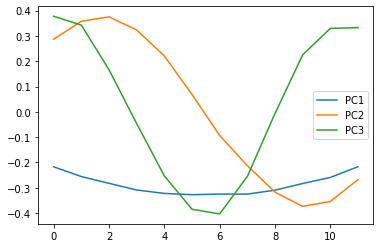

In [72]:
components = pca.components_
for i, component in enumerate(components):
    plt.plot(tr_offsets, component, label=f'PC{i+1}')
plt.legend()
plt.show()

In [73]:
bold_best.shape

(12, 384, 184)

In [75]:
from sklearn.metrics import r2_score

y = pca.transform(X)
X_pred = pca.inverse_transform(y)

r2_score(X, X_pred)

0.5665453128181205

In [76]:
t, p, v = bold_best.shape
y_voxel = rearrange(y, '(p v) c -> c p v', p=p, v=v)

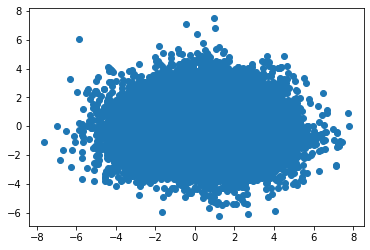

In [106]:
plt.scatter(y[:, 1], y[:, 2])

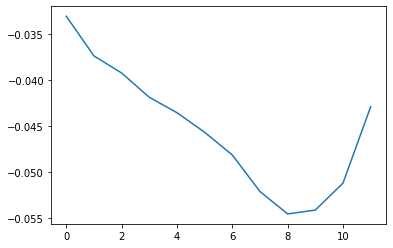

In [121]:
y_norm = np.linalg.norm(y, axis=1)
y_mean = y[y_norm > 2].mean(axis=0)

plt.plot(tr_offsets, pca.inverse_transform(y_mean))
plt.show()

In [123]:
X.mean(axis=0)

array([-3.86802554e-08,  2.88490671e-08,  3.95520345e-08, -1.13492282e-08,
       -2.82771140e-09, -1.18191075e-08,  4.57275995e-08,  2.49693990e-08,
       -6.83830379e-08, -4.86481078e-08,  2.33336794e-09,  2.84331776e-08],
      dtype=float32)